In [3]:
import nltk
import re
import string
import pandas as pd
import numpy as np
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

# from IPython.display import display
# from tqdm import tqdm
# import ast

from sklearn.feature_extraction.text import CountVectorizer
# from textblob import TextBlob
# import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [9]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [14]:
df = pd.read_csv('data/train.csv', sep=';', encoding='utf-8')

In [34]:
n_topics = 5

In [24]:
def replace_symbol(x):
    return x.replace('_', ' ')

def remove_stopwords(article):
    article_tokens = word_tokenize(article) 
    filtered_article = [word for word in article_tokens if not word in stop_words] 
    return " ".join(filtered_article)

In [41]:
# data preprocessing
df_filtered = df.copy()

# removing short texts
df_filtered = df_filtered[(df_filtered['text_employer'].str.len() > 3)]

df_filtered = df_filtered.drop_duplicates(subset=['text_employer'])
df_filtered.text_employer = df_filtered.text_employer.apply(lambda t : t.lower())

stop_words = set(stopwords.words('russian')) 

string.punctuation = string.punctuation.replace('-','')
#removing stopwords, punctuations, digits, correcting phrases like 'добрый_день'
df_filtered.text_employer = df_filtered.text_employer.apply(remove_stopwords)
df_filtered.text_employer = df_filtered.text_employer.apply(replace_symbol)
df_filtered.text_employer = df_filtered.text_employer.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
df_filtered.text_employer = df_filtered.text_employer.apply(lambda x: re.sub('\w*\d\w*','', x))


In [43]:
stopwords.words('russian')

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [22]:
count_vectorizer = CountVectorizer()
document_term_matrix = count_vectorizer.fit_transform(df_filtered.text_employer)

In [35]:
# LSA
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [36]:
def get_keys(topic_matrix):
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [37]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [38]:
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word)
        top_words.append(" ".join(topic_words))         
    return top_words

In [39]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, document_term_matrix, count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  бизнес это карта удобно можете сбербанк звоню день банка менеджер
Topic 2:  зарплатный проект можете тысяч это переводить могу комиссии пожалуйста код
Topic 3:  давай тебе повторное штоб сразу звоним мастер положу лес лесами
Topic 4:  пожалуйста организации информацию линии здравствуйте уточните торговый терминал заявление оставайтесь
Topic 5:  тысяч рублей комиссия месяц процента счет лицо целых процентов тариф


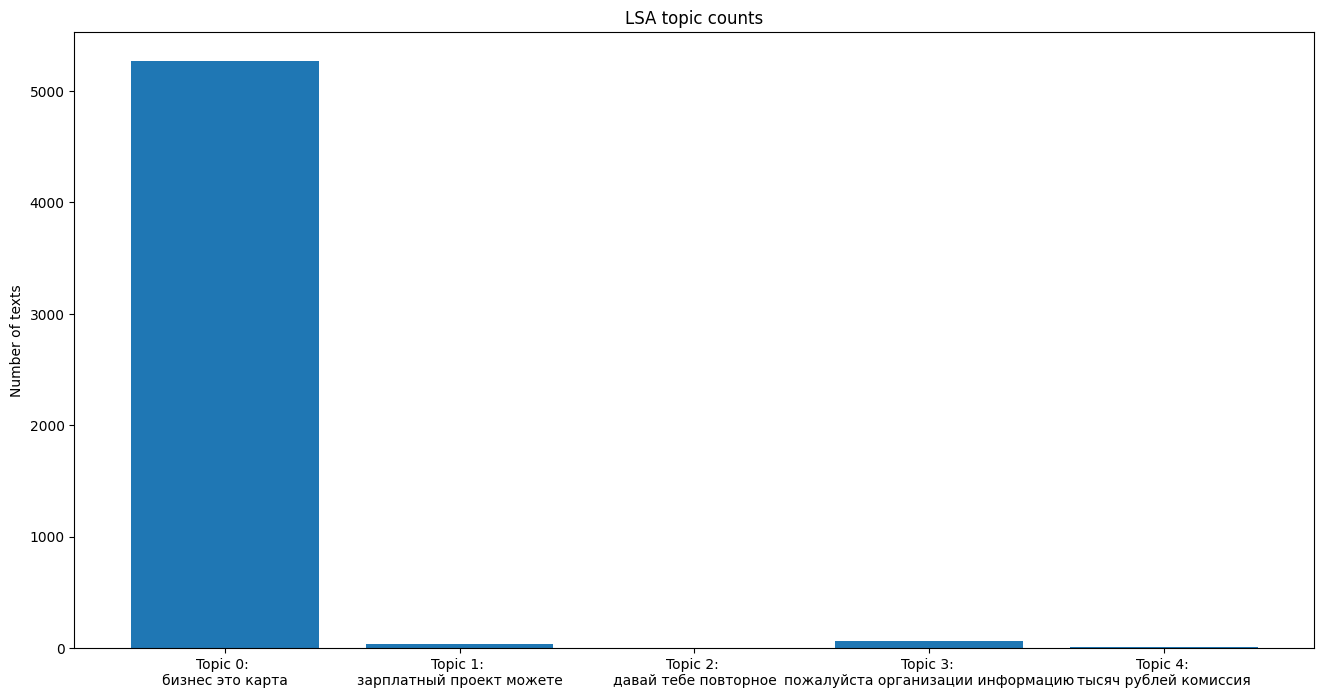

In [44]:
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of texts');
ax.set_title('LSA topic counts');
plt.show()

In [45]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5373 samples in 0.009s...
[t-SNE] Computed neighbors for 5373 samples in 0.411s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5373
[t-SNE] Computed conditional probabilities for sample 2000 / 5373
[t-SNE] Computed conditional probabilities for sample 3000 / 5373
[t-SNE] Computed conditional probabilities for sample 4000 / 5373
[t-SNE] Computed conditional probabilities for sample 5000 / 5373
[t-SNE] Computed conditional probabilities for sample 5373 / 5373
[t-SNE] Mean sigma: 0.237733
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.732224
[t-SNE] KL divergence after 2000 iterations: 1.033088


In [46]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [47]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [52]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), width=700, height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

In [53]:
# LDA
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(document_term_matrix)

In [54]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [55]:
top_n_words_lda = get_top_n_words(10, lda_keys, document_term_matrix, count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  это бизнес карта можете пожалуйста рублей карту карты банка могу
Topic 2:  это банка услуга торговый сбербанк удобно бизнес скажите поняла можете
Topic 3:  бизнес пожалуйста менеджер удобно скажите время сбер звоню персональный вопросы
Topic 4:  бизнес это удобно звоню день добрый менеджер карта сбербанк сбер
Topic 5:  зарплатный это проект можете карта тысяч бизнес комиссии рублей переводить


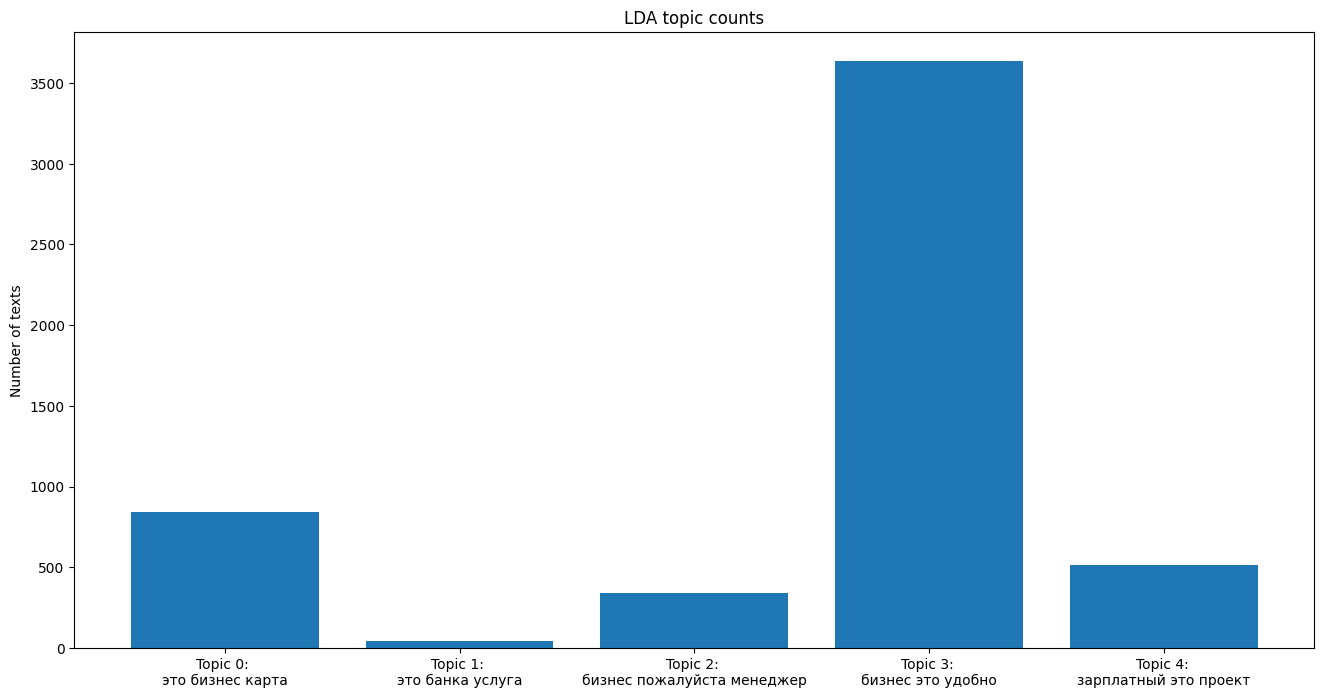

In [56]:
top_3_words = get_top_n_words(3, lda_keys, document_term_matrix, count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of texts');

In [57]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5373 samples in 0.004s...
[t-SNE] Computed neighbors for 5373 samples in 0.273s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5373
[t-SNE] Computed conditional probabilities for sample 2000 / 5373
[t-SNE] Computed conditional probabilities for sample 3000 / 5373
[t-SNE] Computed conditional probabilities for sample 4000 / 5373
[t-SNE] Computed conditional probabilities for sample 5000 / 5373
[t-SNE] Computed conditional probabilities for sample 5373 / 5373
[t-SNE] Mean sigma: 0.000958
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.053379
[t-SNE] KL divergence after 2000 iterations: 0.563353


In [59]:
top_3_words_lda = get_top_n_words(3, lda_keys, document_term_matrix, count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), width=700, height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

In [60]:
# Из визуального сравнения LSA и LDA алгоритмов на 5 темах можно сделать вывод, что LDA лучше выделяет темы. 
# Но все же с первого подхода приблизиться к необходимым темам не удалось. 
# Хочется просто итеративно увеличивать число тем, дальше работать буду только с LDA
# Препроцессинг данных вроде сделан корректно
# При выводе топ слов для каждой темы, было замечено, что попались слова "лес", "лесной".
# Поэтому хочется сделать акцент на изучение текстов, возможно, присутствуют "плохие" темы, которые можно просто отфильтровать
# Также из гистограмм заметно, что присутствует дисбалланс тем
# (фильтрануть редкие слова), (фильтрануть короткие фразы, там мусор иногда - моделька все равно научится на хороших больших текстах)
# (сначала стоп-слова потом лемматизация) (почистить большие пробелы)

In [47]:
for index, row in df_filtered.iterrows():
    if index < 10:
        continue
    print(index, row['text_employer'])
    print('----')
    if index > 1000:
        break

10 добрый  день  это ваш персональный менеджер сбер бизнес звоню индивидуальный предприниматель удобно говорить  удалите пожалуйста минут ваши времени услуги которые бизнес рекомендуют хотела рассказать поводу ваш поводу оплаты договора ваш зарплату договор зарегистрирован можете зачисляются заработный плата прочее выплаты благодарю ваш выбор скажите пожалуйста понятно использовать зарплатный проект нужна какая-то помощь  верно коду  поставьте тысяч рублей комиссии пробовали делал перевод нужно какая-то по-моему моей стороны  переводу  поняла могу перевести линию профильное подразделения мои коллеги смогут посмотреть права доступ ограничено  вижу именно ваш расчетный счет удобно переведу линию поддержки  а поняла любом случае спасибо обратную связь очень важно услышали наших клиентов далее совершенно сервисы отправлю свои контакты придут смс-сообщением номера потребуется оформить услуги сбера дали возникнут какие-то вопросы также например могла перевести линию поддержки посмотрели ваши

In [46]:
for index, row in df.iterrows():
    if index < 10:
        continue
    print(index, row['text_employer'])
    print('----')
    if index > 1000:
        break

10 добрый. тот день. это ваш персональный_менеджер сбер бизнес звоню вам как индивидуальный_предприниматель удобно говорить вам сейчас. удалите пожалуйста минут ваши времени есть услуги которые бизнес рекомендуют хотела у них рассказать а по поводу за ваш по поводу оплаты договора то есть ваш зарплату договор зарегистрирован теперь вы можете зачисляются заработный_плата и прочее выплаты благодарю вас за ваш выбор скажите пожалуйста все понятно по использовать зарплатный_проект нужна ли вам какая-то помощь. все верно по коду. поставьте тысяч рублей без комиссии вы уже пробовали делал перевод и может быть нужно какая-то по-моему с моей стороны. по переводу. я вас поняла могу вас перевести сейчас на линию на профильное подразделения то есть мои коллеги смогут посмотреть у меня права доступ ограничено. я не вижу именно ваш расчетный счет удобно вам будет если вас сейчас переведу на линию поддержки. а. я вас поняла в любом случае спасибо вам за обратную связь очень важно чтобы мой услышали 

In [ ]:
# Изучал текста с целью поиска плохих тематик и слов. Можно расширить список стоп-слов под конкретную тематику
# добавить: ['э', 'а', 'м', 'же', 'у', 'box', 'санкт-петербург', 'москва', 'это', 'лопух', 'вот', 'там', 'психоз', 'ну',
# 'этот', 'уже, 'сантиметров', 'жесткая', 'она', 'прям', 'вообще', 'пошел', 'звоним', 'штоб', 'бога', 'на', 'максим',
# 'или', 'мастер', 'кого', 'ой', 'по', 'выходной', 'давай', 'истории']

# удалить: ['сейчас', 'через', 'какое', 'могу', 'тогда']

In [ ]:
# есть проблемы с транскрибацией диалогов:
# удалите пожалуйста ваше время; поинтересо; зарабатывать на своих покупка;

# иногда присутствует болтовня звонящего до момента, когда клиент снял трубку (по хорошему бы уметь находить момент поднятия трубки)
# в истории смотреть... здравствуйте;